In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torchvision.models import resnet34, ResNet34_Weights
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

## Preprocessing and Feature Extraction

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.fc = nn.Identity()
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def extract_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)

    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img)

    return features.squeeze().cpu().numpy()

In [6]:
feature_list = []
image_names = []
for image_path in os.listdir("faces"):
    if image_path.endswith(".jpg"):
        features = extract_features(os.path.join("faces", image_path))
        feature_list.append(features)
        image_names.append(image_path)

In [7]:
features = np.array(feature_list)

In [8]:
features

array([[0.16722275, 0.05252771, 0.19711673, ..., 1.2881405 , 1.7179745 ,
        0.4431712 ],
       [0.29530263, 0.56057495, 0.14762665, ..., 1.1235942 , 0.08442286,
        0.37302324],
       [0.5315641 , 0.6925713 , 1.2303971 , ..., 0.8579261 , 0.11778807,
        0.13113046],
       ...,
       [0.84157956, 0.8058645 , 0.49772763, ..., 0.60978407, 0.91546696,
        0.00943048],
       [0.5140611 , 0.63674676, 2.1254435 , ..., 1.2695175 , 0.1741225 ,
        0.02355107],
       [0.09813651, 0.64918166, 1.2144786 , ..., 1.1375089 , 0.04082254,
        0.8044844 ]], dtype=float32)

In [9]:
df = pd.DataFrame(features)
df.insert(0, 'Image Name', image_names)
df.to_csv('features.csv', index=False)

In [10]:
df = pd.read_csv('features.csv')
df

Image Name         0         1         2         3  \
0     10003541_1937-09-27_1971.jpg  0.167223  0.052528  0.197117  1.403379   
1     10004299_1908-08-19_1950.jpg  0.295303  0.560575  0.147627  0.148633   
2     10005947_1981-04-07_2006.jpg  0.531564  0.692571  1.230397  1.840570   
3     10006850_1973-08-17_2010.jpg  0.038627  0.391582  0.240080  0.735266   
4      1000781_1930-07-07_2008.jpg  0.027990  0.644064  0.354977  1.459265   
...                            ...       ...       ...       ...       ...   
8619   9979824_1966-11-03_2008.jpg  0.425289  1.209261  2.230951  2.532599   
8620   9980109_1971-05-09_2014.jpg  0.570829  0.877508  0.043461  3.394836   
8621   9996683_1929-12-19_2008.jpg  0.841580  0.805864  0.497728  1.502671   
8622   9996763_1933-10-02_2008.jpg  0.514061  0.636747  2.125443  2.165727   
8623   9996824_1937-03-04_1962.jpg  0.098137  0.649182  1.214479  0.113671   

             4         5         6         7         8  ...       502  \
0     0.004028  0.350199  0.041637  0.846253  0.011490  ...  1.505452   
1     0.083633  0.756155  0.010373  0.187425  0.245777  ...  0.142504   
2     0.012356  0.013969  0.306114  1.103996  1.239578  ...  0.206027   
3     0.013004  0.029343  0.793633  0.085668  0.019546  ...  0.246701   
4     0.269854  1.376712  0.095513  1.157090  0.037941  ...  0.281456   
...        ...       ...       ...       ...       ...  ...       ...   
8619  1.434160  1.169575  1.310359  0.788094  0.526419  ...  0.349572   
8620  0.125024  1.475324  0.391504  0.557894  0.023650  ...  0.130413   
8621  0.376875  0.669647  0.332008  1.191234  0.261656  ...  1.919843   
8622  0.254266  1.365607  1.753959  0.662989  0.135733  ...  1.002496   
8623  0.029012  0.652949  0.040084  0.028790  0.143577  ...  0.000172   

           503       504       505       506       507       508       509  \
0     0.005799  0.722697  0.406628  0.219031  0.654528  0.545009  1.288140   
1     0.067107  2.113221  0.171248  1.049152  0.211254  0.084018  1.123594   
2     0.052111  0.411476  0.441548  0.606879  0.177223  0.776901  0.857926   
3     0.775610  0.746918  0.014426  2.546791  0.127904  0.608544  0.359910   
4     0.606690  1.240728  0.177480  3.383624  0.437968  0.068866  0.735867   
...        ...       ...       ...       ...       ...       ...       ...   
8619  0.094153  1.074548  0.083105  3.736792  1.455255  3.345130  2.155098   
8620  0.725100  1.159213  0.231002  3.664370  2.195410  0.830726  0.510396   
8621  0.288910  1.191088  0.000364  1.443875  1.044826  0.670764  0.609784   
8622  0.620521  0.172862  0.105835  3.403685  1.024804  0.085074  1.269518   
8623  0.389525  1.631039  0.612464  1.234447  0.284840  0.000356  1.137509   

           510       511  
0     1.717974  0.443171  
1     0.084423  0.373023  
2     0.117788  0.131130  
3     0.051739  0.142239  
4     0.022145  0.168094  
...        ...       ...  
8619  0.493607  0.161751  
8620  0.073238  0.053436  
8621  0.915467  0.009430  
8622  0.174123  0.023551  
8623  0.040823  0.804484  

[8624 rows x 513 columns]

In [11]:
model = model.to('cpu')

## Grad-CAM

[182 473 220 361  70 256 141 496 492  90]


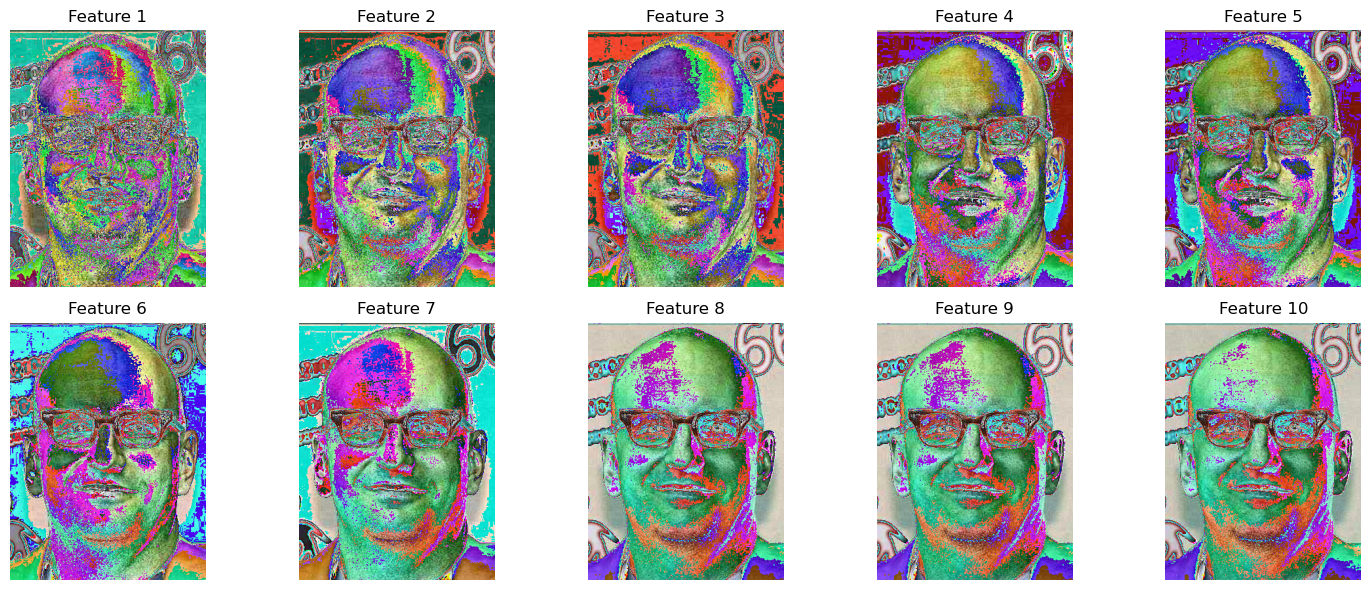

In [12]:
def grad_cam(model, image_path, top_k=10):
    model.eval()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image_pil).unsqueeze(0)

    with torch.no_grad():
        features = model(image_tensor)

    top_features = torch.topk(features, k=top_k)[1].squeeze().cpu().numpy()
    print(top_features)

    plt.figure(figsize=(15, 6))
    for i, feature_index in enumerate(top_features):
        highlighted_image = image * features[0, feature_index].item()
        plt.subplot(top_k // 5, 5, i + 1)
        plt.imshow(highlighted_image.astype(np.uint8))
        plt.title(f'Feature {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_path = "faces/27337_1963-01-14_2009.jpg"
grad_cam(model, image_path)

## Grad-CAM with Top Features Frequency

In [13]:
def grad_cam_top_features(model, image_path, top_k=10):
    model.eval()

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image_pil).unsqueeze(0)

    with torch.no_grad():
        features = model(image_tensor)

    top_features = torch.topk(features, k=top_k)[1].squeeze().cpu().numpy()

    importance_scores = features.squeeze().cpu().numpy()
    top_feature_importance = [(feature_index, importance_scores[feature_index]) for feature_index in top_features]
    return top_feature_importance


def find_top_n_features(images, top_n=10, top_k=10):
    feature_frequency = Counter()

    for image_path in tqdm(images, desc="Processing images"):
        top_feature_importance = grad_cam_top_features(model, image_path, top_k=top_k)
        top_n_features = top_feature_importance[:top_n]

        for feature_index, _ in top_n_features:
            feature_frequency[feature_index] += 1

    top_n_features = feature_frequency.most_common(top_n)
    return top_n_features

In [14]:
images_folder = "faces"
image_paths = [os.path.join(images_folder, img) for img in os.listdir(images_folder) if img.endswith(".jpg")]

top_n_features = find_top_n_features(image_paths)
print("Top n features with most appearance:")
for feature_index, frequency in top_n_features:
    print(f"Feature {feature_index}: {frequency} times")

Processing images: 100%|██████████| 8624/8624 [06:14<00:00, 23.01it/s]

Top n features with most appearance:
Feature 182: 8338 times
Feature 497: 5580 times
Feature 78: 5528 times
Feature 70: 4686 times
Feature 361: 4254 times
Feature 186: 3994 times
Feature 220: 3408 times
Feature 221: 3366 times
Feature 326: 3275 times
Feature 224: 2109 times


In [34]:
top_features = [tup[0] for tup in top_n_features]
top_features

[182, 497, 78, 70, 361, 186, 220, 221, 326, 224]

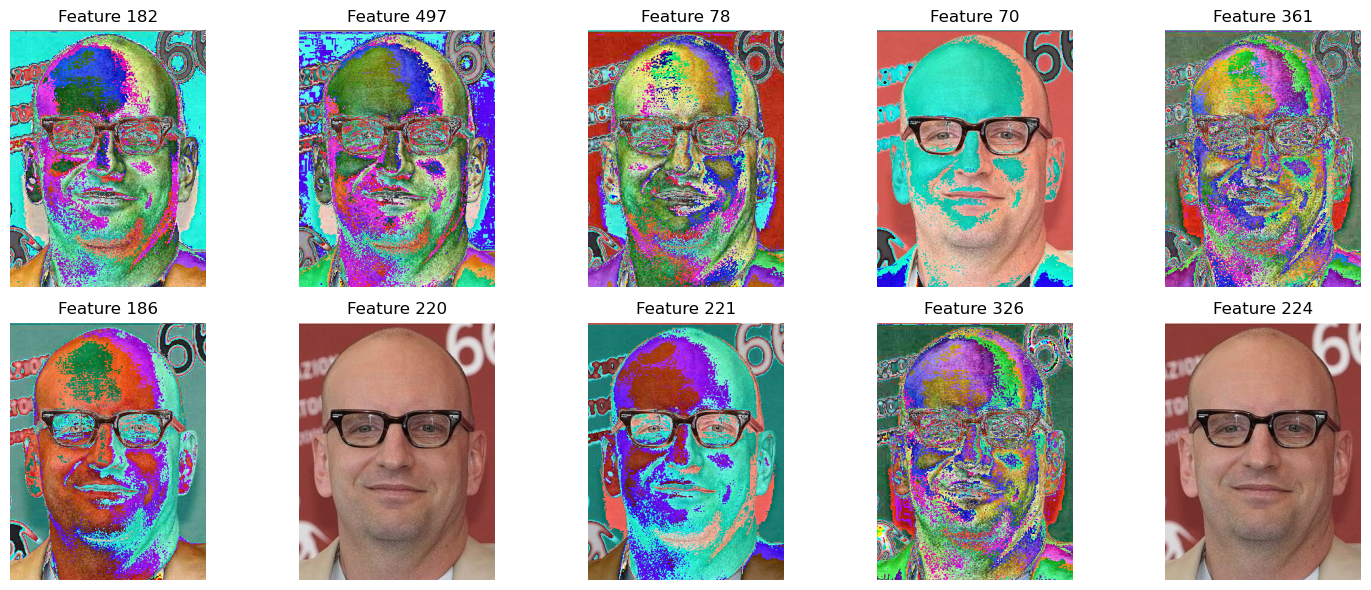

In [35]:
image_path = "faces/27337_1963-01-14_2009.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 6))
for i, feature_index in enumerate(top_features):
    highlighted_image = image * features[0, feature_index].item()
    plt.subplot(10 // 5, 5, i + 1)
    plt.imshow(highlighted_image.astype(np.uint8))
    plt.title(f'Feature {feature_index}')
    plt.axis('off')
plt.tight_layout()
plt.show()

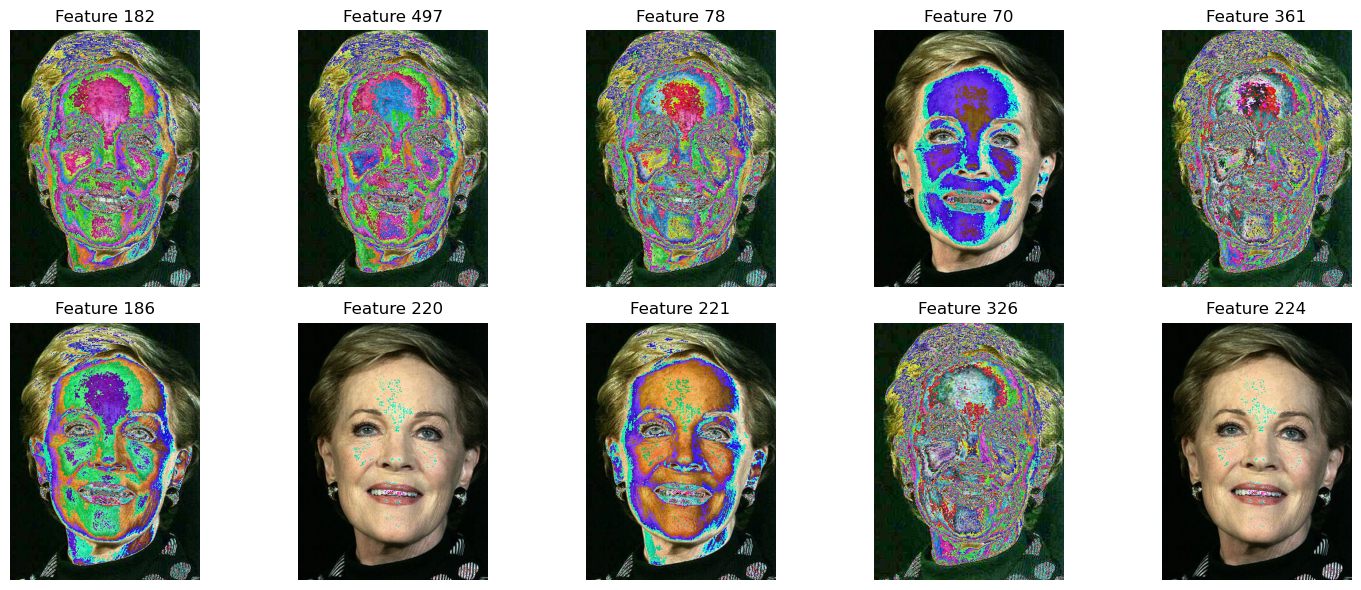

In [36]:
image_path = "faces/78239_1935-10-01_2013.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 6))
for i, feature_index in enumerate(top_features):
    highlighted_image = image * features[0, feature_index].item()
    plt.subplot(10 // 5, 5, i + 1)
    plt.imshow(highlighted_image.astype(np.uint8))
    plt.title(f'Feature {feature_index}')
    plt.axis('off')
plt.tight_layout()
plt.show()